# Single NFW profile

Here we demonstrate most of the functionality using a single NFW profile.

In [1]:
import profiley
profiley.__version__

'2.0.0a11'

For nicer layout (feel free to comment out)

In [2]:
from plottery.plotutils import update_rcParams
update_rcParams()

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from profiley.nfw import NFW

In [4]:
mass = 1e14
concentration = 4
redshift = 0.5

In [5]:
mass = np.array([1e14])

In [6]:
nfw = NFW(mass, concentration, redshift)
print(nfw)

NFW profile object containing 1 profiles
shape: (1,)
  overdensity: 500c
  log10 mass/Msun = 14.00
  concentration = 4.00
  redshift = 0.50


Note that the profile attributes are always arrays, even if scalars are passed to it.

The first thing to look at is the 3-dimensional density profile. For all profiles we need to pass the distances at which these will be computed, as a 1d array, so let's define that first.
These distances must be in Mpc.

In [7]:
R = np.logspace(-2, 1, 500)

With that, getting the density profile is as simple as

In [8]:
rho = nfw.profile(R)

That's it!

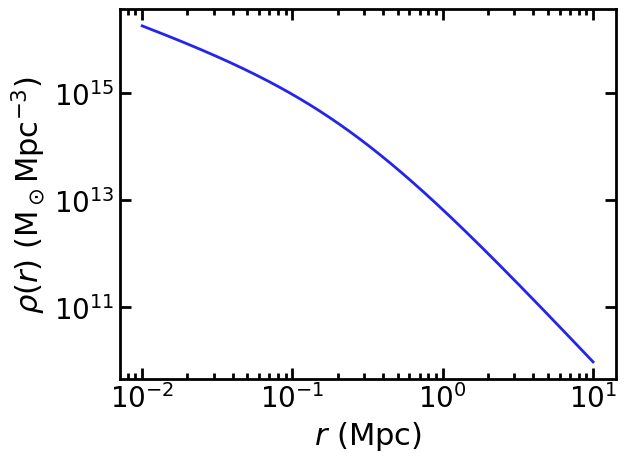

In [9]:
fig, ax = plt.subplots()
ax.loglog(R, rho)
ax.set(xlabel='$r$ (Mpc)', ylabel='$\\rho(r)$ (M$_\\odot$Mpc$^{-3}$)');

Similarly, we can obtain the projected surface density or the excess surface density (the weak lensing observable):

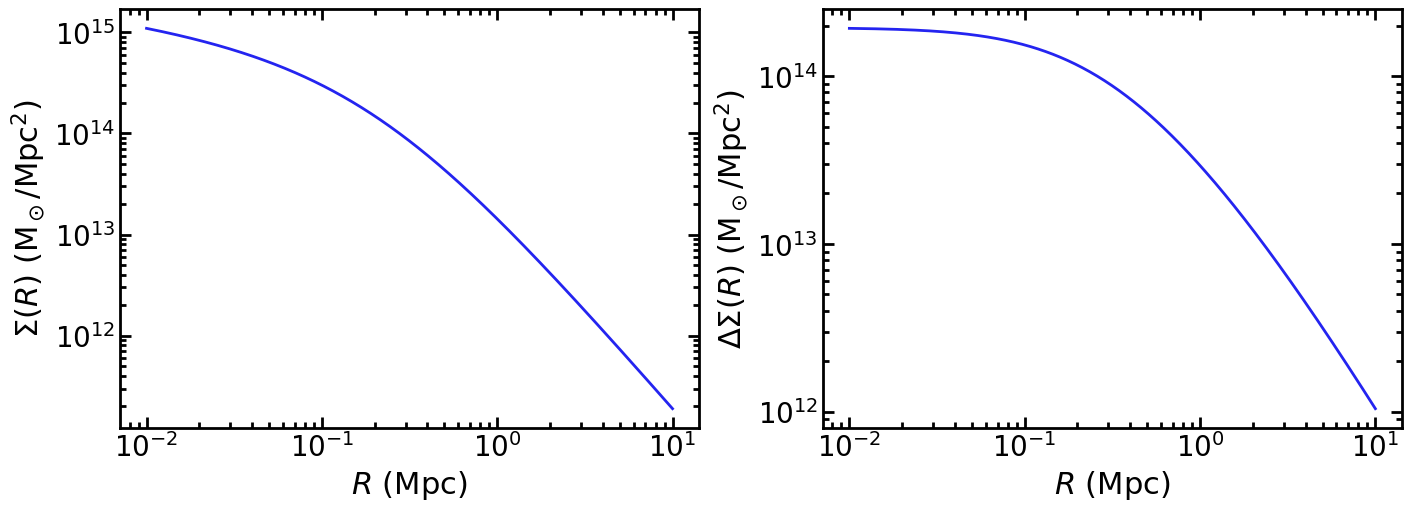

In [10]:
sigma = nfw.projected(R)
esd = nfw.projected_excess(R)

fig, axes = plt.subplots(figsize=(14,5), ncols=2, constrained_layout=True)
axes[0].loglog(R, sigma)
axes[0].set_ylabel('$\\Sigma(R)$ (M$_\\odot$/Mpc$^2$)')
axes[1].loglog(R, esd)
axes[1].set_ylabel('$\\Delta\\Sigma(R)$ (M$_\\odot$/Mpc$^2$)')
for ax in axes:
    ax.set(xlabel='$R$ (Mpc)')

The ESD can also be calculated "manually":

In [11]:
barsigma = nfw.projected_cumulative(R)
esd_manual = barsigma - sigma
np.allclose(esd, esd_manual)

True

We can also calculate the convergence profile for a given source redshift:

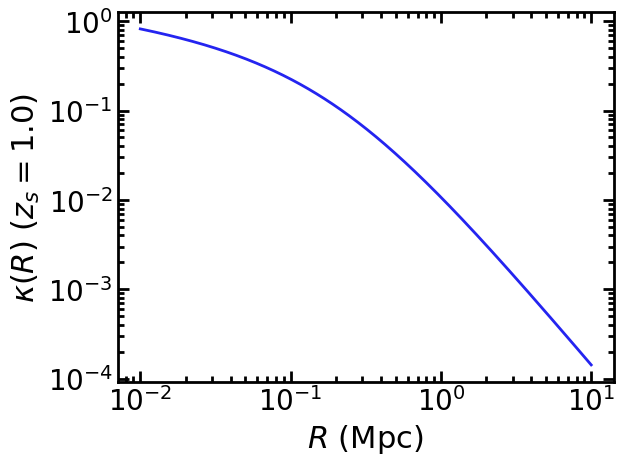

In [12]:
z_source = 1.0
kappa = nfw.convergence(R, z_source)

fig, ax = plt.subplots()
ax.loglog(R, kappa)
ax.set(xlabel='$R$ (Mpc)', ylabel=f'$\\kappa(R)$ ($z_s={z_source}$)');

Finally, we can also obtain offset profiles using the `offset` function from the `numeric` submodule:

In [13]:
from profiley.numeric import offset

Roff = np.linspace(0.2, 1, 5)
sigma_off = offset(sigma.T, R, Roff)
sigma_off.shape

(1, 5, 500)

Note that, as stated in the docs, we had to transpose `sigma` to pass it to `offset`. The resulting shape is similarly transposed with respect to the usual: it is `(*nfw.shape, Roff.size, *R.shape)` instead of `(Roff.size, *R.shape, *nfw.shape)`. This will be fixed when `offset` is merged as a `Profile` method.

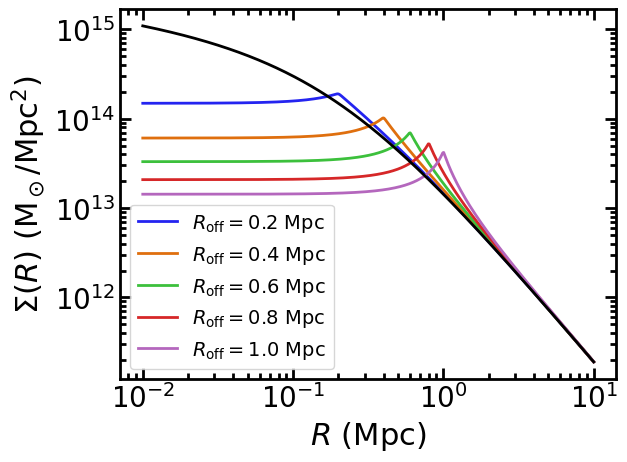

In [14]:
fig, ax = plt.subplots()
for Ri, sigma_i in zip(Roff, sigma_off[0]):
    ax.loglog(R, sigma_i, label=f'$R_\\mathrm{{off}}={Ri:.1f}$ Mpc')
ax.plot(R, sigma, 'k-')
ax.legend(fontsize=14)
ax.set(xlabel='$R$ (Mpc)', ylabel='$\\Sigma(R)$ (M$_\\odot$/Mpc$^2$)');

It's possible to do this for any other profile. For instance, the convergence:

In [15]:
kappa_off = offset(kappa.T, R, Roff)
kappa_off.shape

(1, 5, 500)

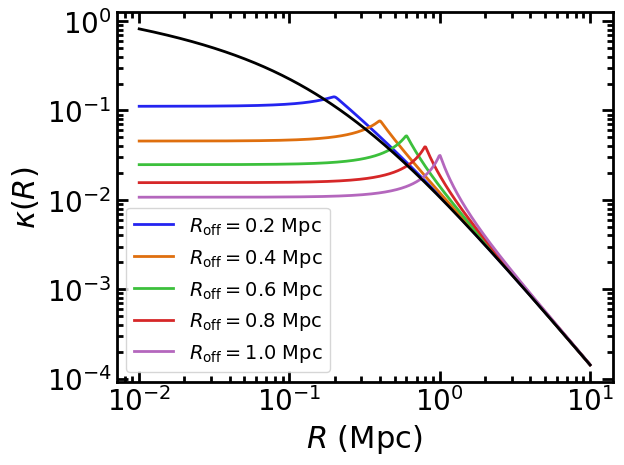

In [16]:
fig, ax = plt.subplots()
for Ri, kappa_i in zip(Roff, kappa_off[0]):
    ax.loglog(R, kappa_i, label=f'$R_\\mathrm{{off}}={Ri:.1f}$ Mpc')
ax.plot(R, kappa, 'k-')
ax.legend(fontsize=14)
ax.set(xlabel='$R$ (Mpc)', ylabel='$\\kappa(R)$');

These various offset profiles can be combined following an off-centering distribution to obtain a mean off-centered profile. Let's sample `Roff` more finely to make it look nice, including a well-centered component (for the fraction of well-centered measurements), and create Gaussian weights:

[Text(0.5, 0, '$R_\\mathrm{off}$ (Mpc)'), Text(0, 0.5, '$p(R_\\mathrm{off})$')]

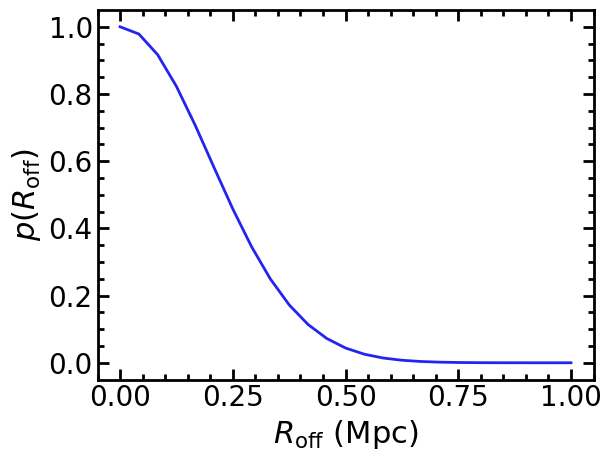

In [17]:
Roff = np.linspace(0, 1, 25)
weights = np.exp(-Roff**2 / (2*0.2**2))
fig, ax = plt.subplots()
ax.plot(Roff, weights)
ax.set(xlabel='$R_\\mathrm{off}$ (Mpc)', ylabel='$p(R_\\mathrm{off})$')

In [18]:
Roff.shape, weights.shape, kappa.shape

((25,), (25,), (500, 1))

In [19]:
kappa_off_mean = offset(kappa.T, R, Roff, weights=weights)
kappa_off_mean.shape

(1, 500)

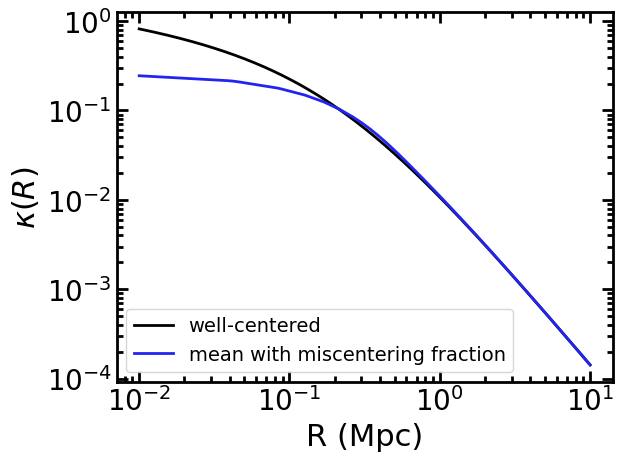

In [20]:
fig, ax = plt.subplots()
ax.loglog(R, kappa[:,0], 'k-', label='well-centered')
ax.plot(R, kappa_off_mean[0], label='mean with miscentering fraction')
ax.set(xlabel='R (Mpc)', ylabel=r'$\kappa(R)$')
ax.legend(fontsize=14);